# 👖 패션 MNIST를 사용한 오토인코더

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/03_vae/01_autoencoder/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

이 노트북에서는 패션 MNIST 데이터셋으로 오토인코더를 훈련합니다.

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks

--2023-05-16 13:57:36--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2023-05-16 13:57:37 (36.1 MB/s) - ‘utils.py’ saved [771/771]



In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

from notebooks.utils import display

## 0. 파라미터 <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

## 1. 데이터 준비 <a name="prepare"></a>

In [4]:
# 데이터를 로드합니다.
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [5]:
# 데이터 전처리
def preprocess(imgs):
    """
    이미지를 정규화하고 크기를 변경합니다.
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

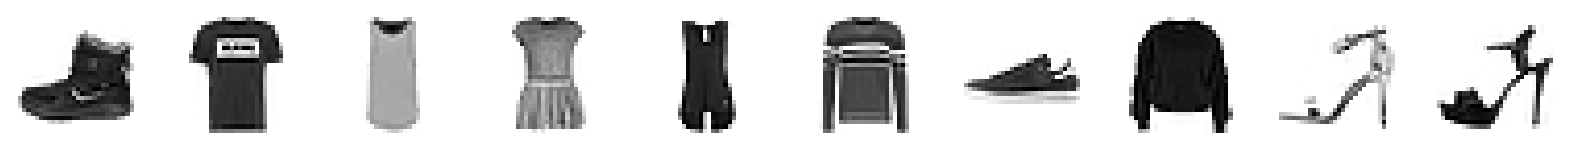

In [6]:
# 훈련 세트에 있는 의류 아이템 일부를 출력합니다.
display(x_train)

## 2. 오토인코더 만들기 <a name="build"></a>

In [7]:
# 인코더
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # 디코더에 필요합니다!

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96,770
Trainable params: 96,770
Non-trainable p

In [8]:
# 디코더
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       1846

In [9]:
# 오토인코더
autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_1 (Functional)        (None, 32, 32, 1)         2462

## 3. 오토인코더 훈련하기 <a name="train"></a>

In [10]:
# 오토인코더 컴파일
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [11]:
# 모델 저장 체크포인트 생성
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [12]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/3
598/600 [============================>.] - ETA: 0s - loss: 0.2865

600/600 [==============================] - 25s 15ms/step - loss: 0.2864 - val_loss: 0.2600
Epoch 2/3
597/600 [============================>.] - ETA: 0s - loss: 0.2571

600/600 [==============================] - 8s 14ms/step - loss: 0.2571 - val_loss: 0.2566
Epoch 3/3
599/600 [============================>.] - ETA: 0s - loss: 0.2542

600/600 [==============================] - 8s 13ms/step - loss: 0.2542 - val_loss: 0.2546


In [13]:
# 최종 모델을 저장합니다.
autoencoder.save("./models/autoencoder")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

## 4. 오토인코더를 사용해 재구성하기 <a name="reconstruct"></a>

In [14]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 1s 3ms/step
실제 의류 아이템


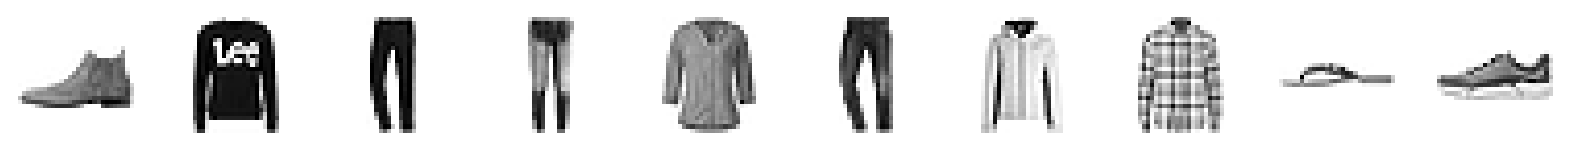

재구성 이미지


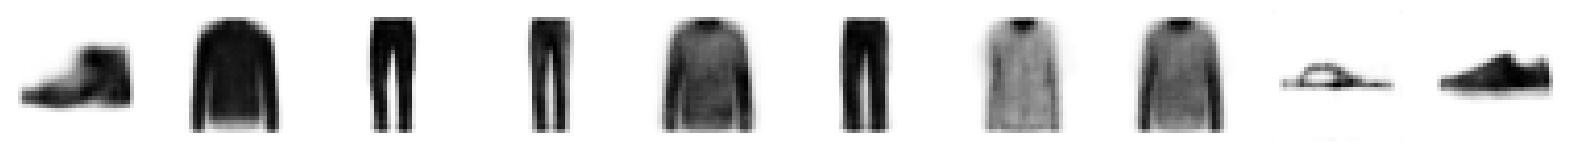

In [15]:
predictions = autoencoder.predict(example_images)

print("실제 의류 아이템")
display(example_images)
print("재구성 이미지")
display(predictions)

## 5. 인코더를 사용해 임베딩하기 <a name="encode"></a>

In [16]:
# 샘플 이미지를 인코딩합니다.
embeddings = encoder.predict(example_images)

157/157 [==============================] - 0s 2ms/step


In [17]:
# 몇 개의 임베딩을 출력합니다.
print(embeddings[:10])

[[ 0.6022296  -2.2042968 ]
 [ 6.145397    0.21255577]
 [ 1.589079    6.271163  ]
 [ 0.60717785  3.8057735 ]
 [ 3.3867915  -0.17258367]
 [ 2.1577969   4.876937  ]
 [ 1.9041805   0.6365765 ]
 [ 2.892411    0.16576965]
 [-2.0834181  -2.3144565 ]
 [-0.91328967 -3.9816248 ]]


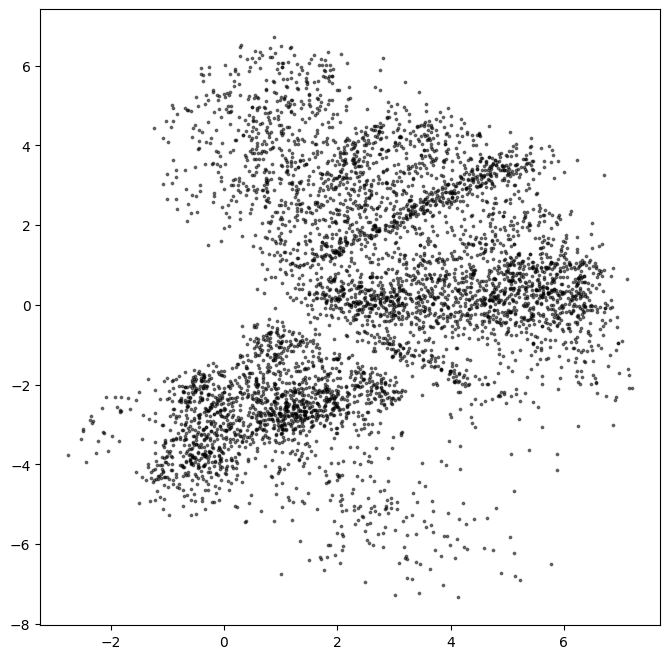

In [18]:
# 2D 공간에 인코딩된 포인트를 출력합니다.
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

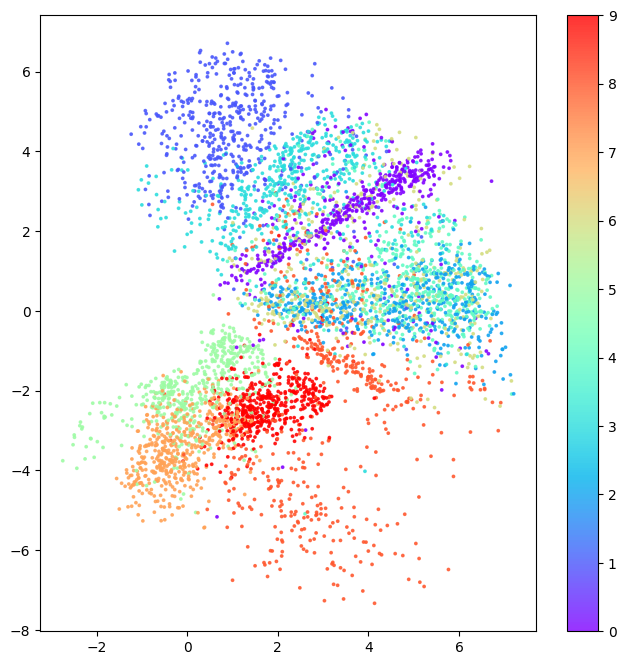

In [19]:
# 레이블(의류 종류)에 따라 임베딩에 색을 입힙니다.
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

## 6. 디코더를 사용해 생성하기 <a name="decode"></a>

In [20]:
# 기존의 임베딩 범위 구하기
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# 잠재 공간에서 포인트를 샘플링합니다.
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [21]:
# 샘플링된 포인트를 디코딩합니다.
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 227ms/step


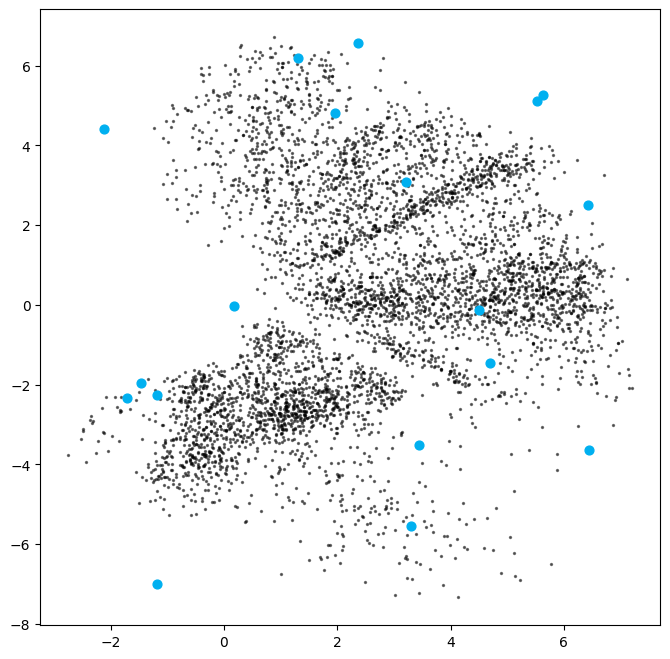

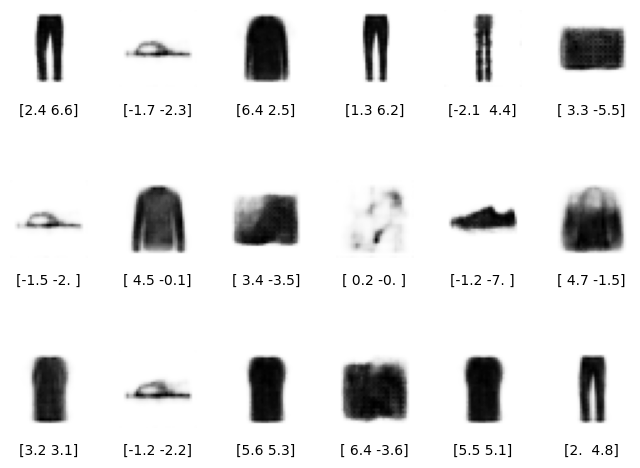

In [22]:
# 그래프로 그립니다.
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... 원본 임베딩 ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... 잠재 공간에서 새로 생성된 포인트
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# 디코딩된 이미지 그리드 추가
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 [==============================] - 0s 2ms/step


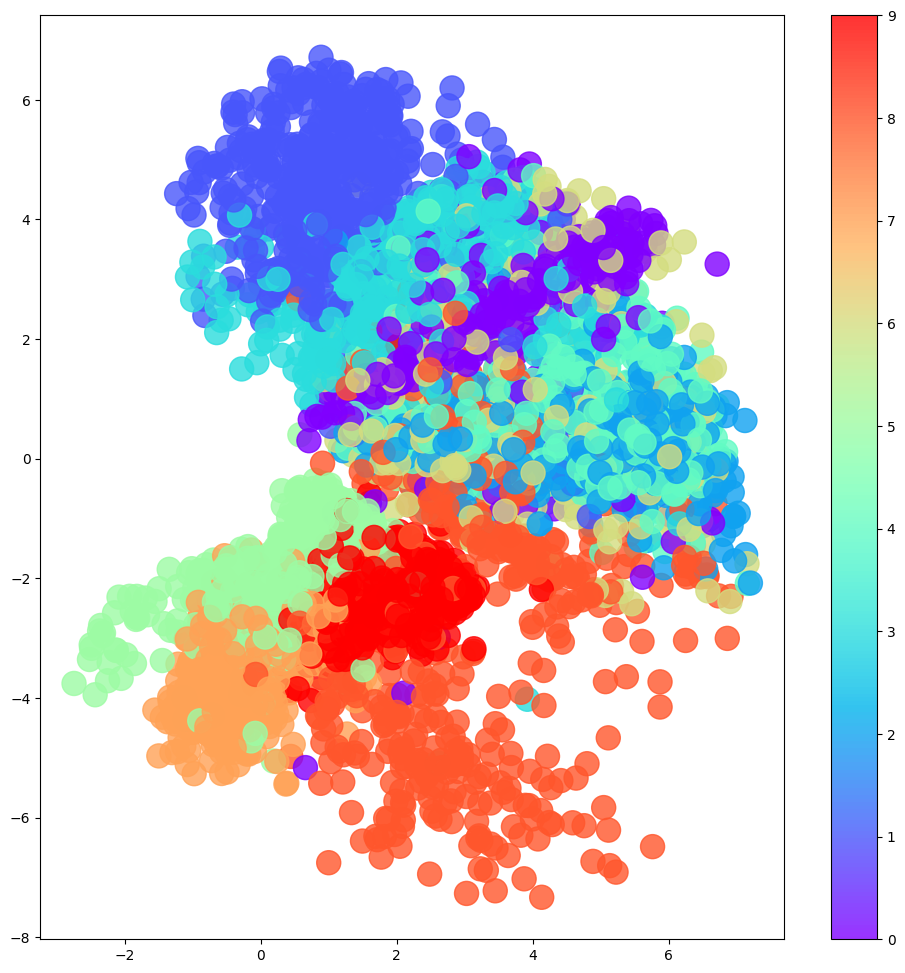

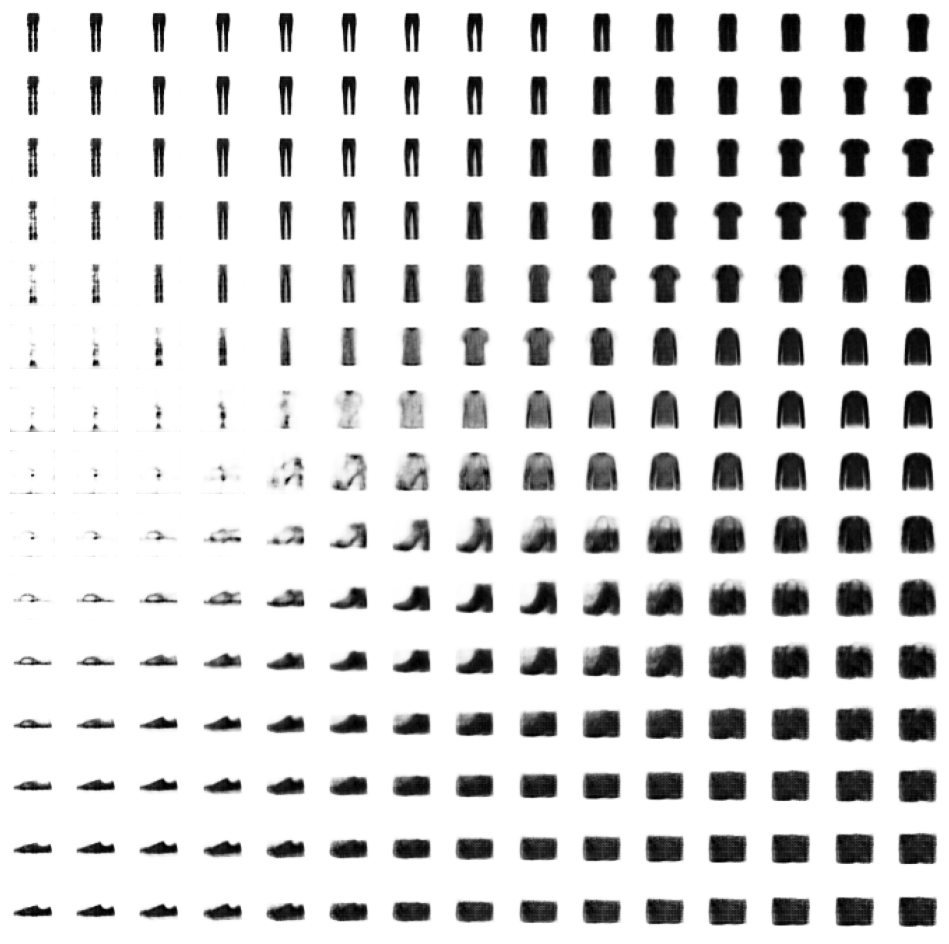

In [25]:
# 레이블(의류 종류)에 따라 임베딩에 색을 입힙니다.
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")